# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

[14:24:37] WARNING  Converting throat.conns to be upper triangular                                  ]8;id=742279;file:///Users/tleo/micromamba/envs/pnm_dev/lib/python3.11/site-packages/openpnm/network/_network.py\_network.py]8;;\:]8;id=189600;file:///Users/tleo/micromamba/envs/pnm_dev/lib/python3.11/site-packages/openpnm/network/_network.py#126\126]8;;\

{'alpha_radial': 0.00012997486546235373, 'alpha_spiral': 0.0018925822276459076, 'lump_rho': 2499.316300105252, 'lump_Cp': 8247.24639489116}
216


Initialising simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Finished step 0


Initialising simulation:  20%|██        | 1/5 [09:52<39:29, 592.34s/it]

Finished step 1


Initialising simulation:  40%|████      | 2/5 [19:26<29:04, 581.44s/it]

Finished step 2


Initialising simulation:  60%|██████    | 3/5 [29:01<19:17, 578.81s/it]

Finished step 3


Initialising simulation:  80%|████████  | 4/5 [38:35<09:36, 576.76s/it]

Finished step 4


Stepping simulation:   0%|          | 0/361 [00:00<?, ?it/s]

Finished step 0


Stepping simulation:   0%|          | 1/361 [09:46<58:40:03, 586.68s/it]

Finished step 1


[15:22:47] WARNING  Low voltage limit reached                                                        ]8;id=305311;file:///Users/tleo/Code/Ionworks/liionpack/liionpack/liionpack/solvers.py\solvers.py]8;;\:]8;id=576825;file:///Users/tleo/Code/Ionworks/liionpack/liionpack/liionpack/solvers.py#290\290]8;;\

Stepping simulation:   1%|          | 2/361 [19:31<58:25:27, 585.87s/it]


******************************
ECM Sim time 4074.5261352062225
******************************


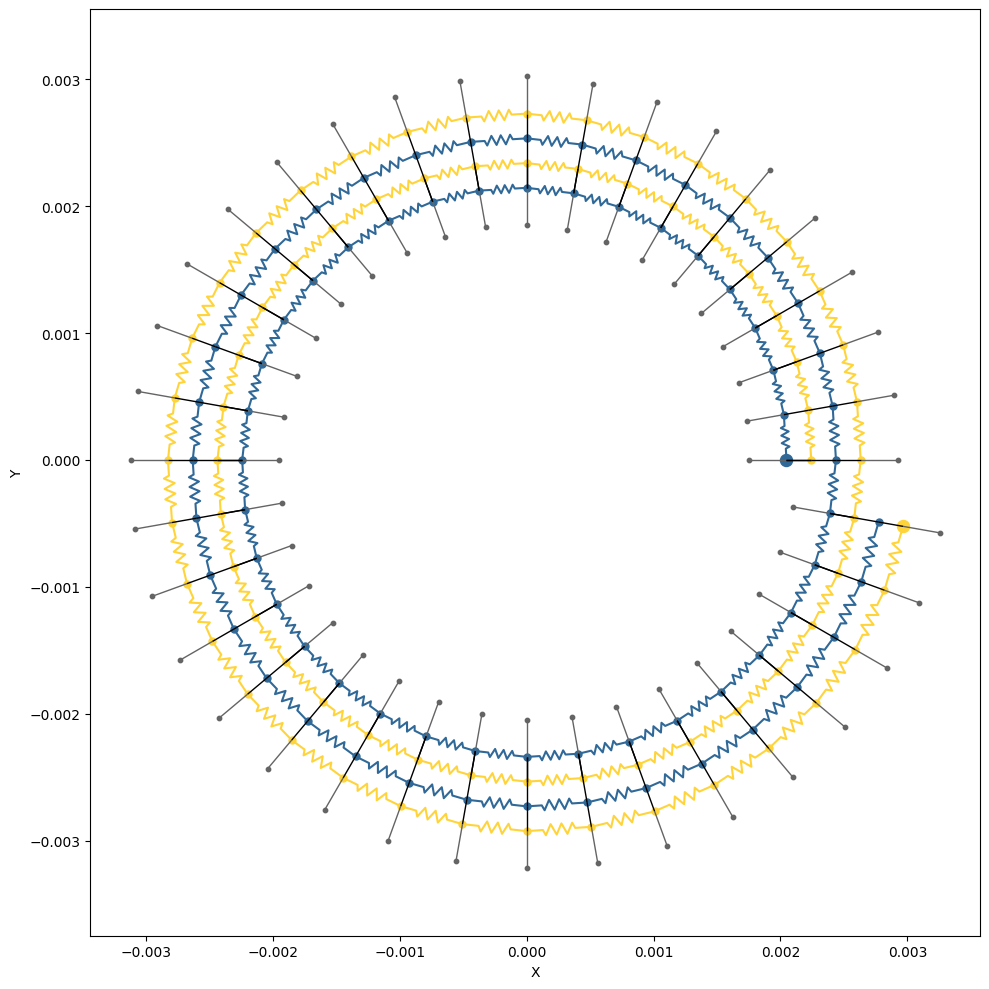

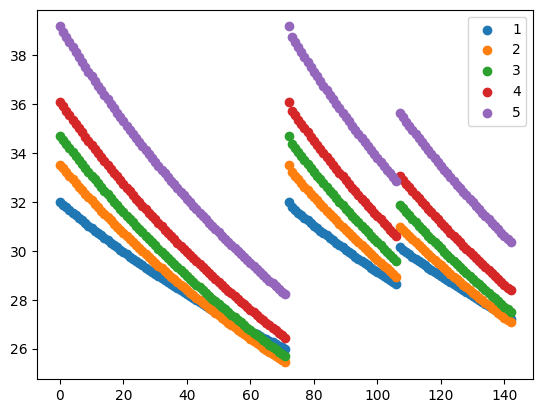

In [2]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

# Geometry of spiral
Nlayers = 2  #NOTE Full sim uses 20 layers
dtheta = 10
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 360
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours or until 2.5 V",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)
ecm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Chen2020")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = None
thermal_props = print(ecm.lump_thermal_props(param))
print(project.network.Np)

# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=initial_soc,
                                        project=project)

In [ ]:
net = project.network

net.interpolate_data('pore.radial_position')
# net['throat.radial_position'] = 0

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
net['throat.radial_position']

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
net = project.network
net.num_pores('free_stream')

36

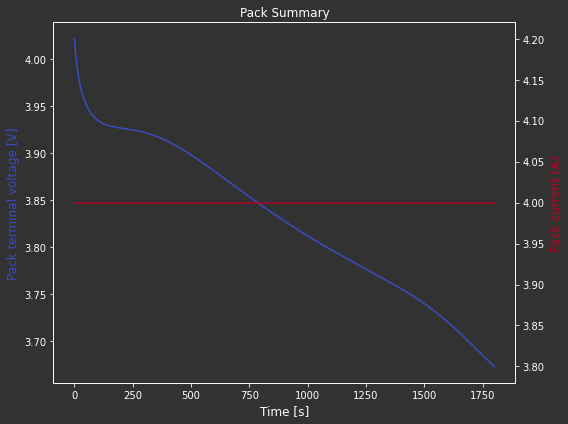

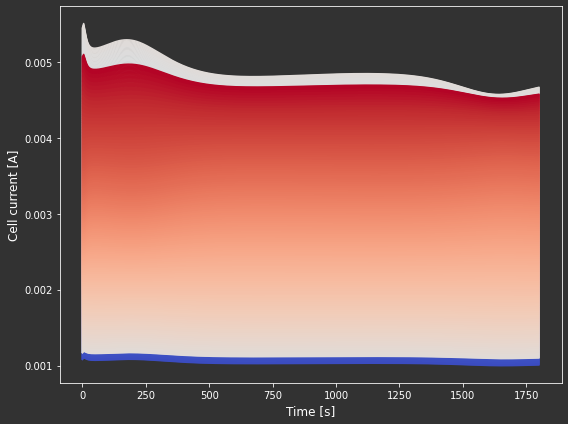

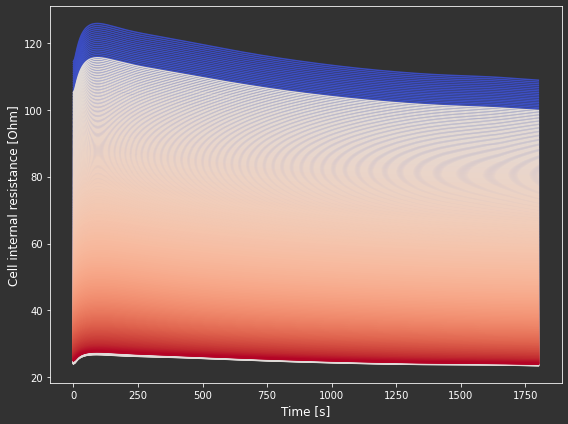

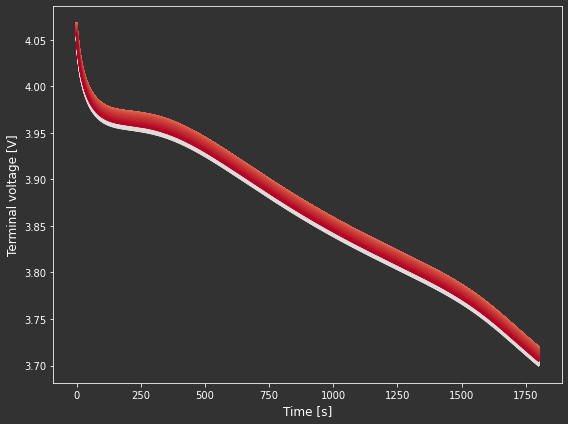

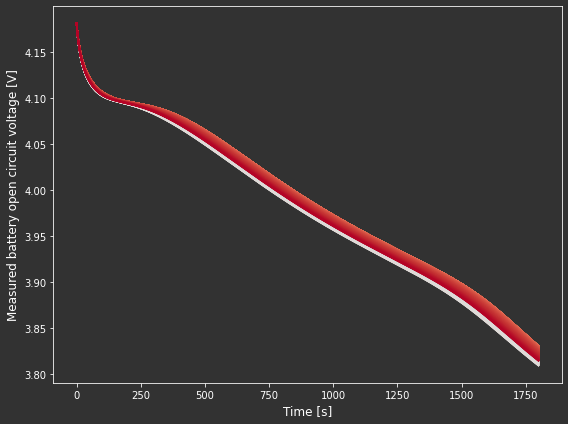

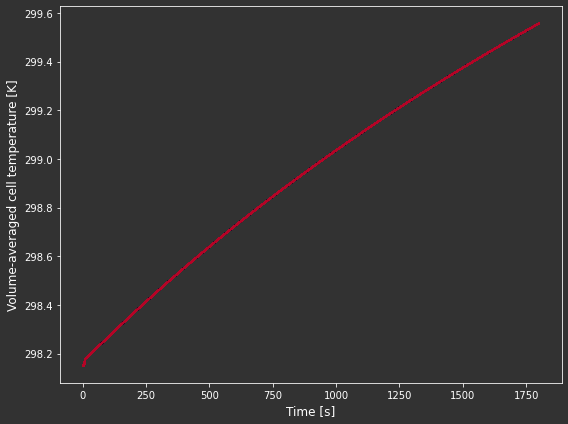

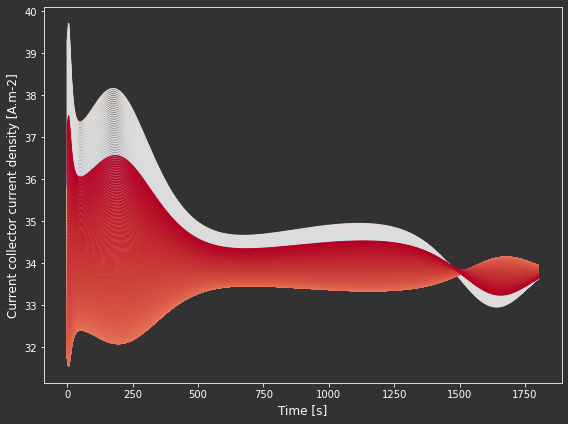

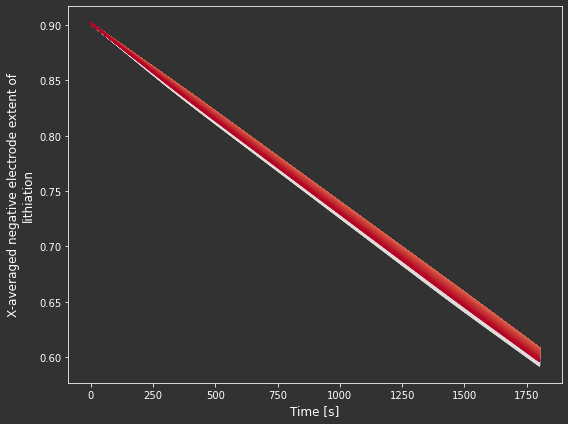

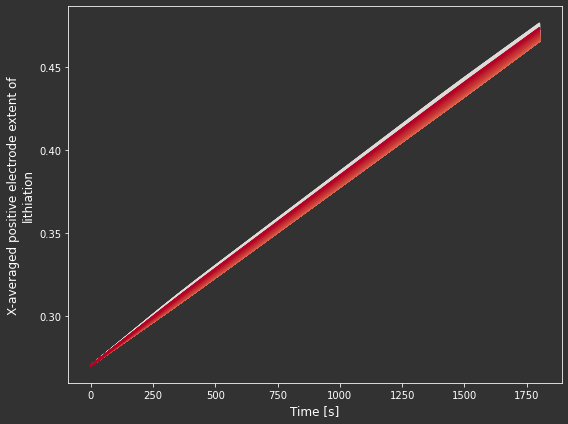

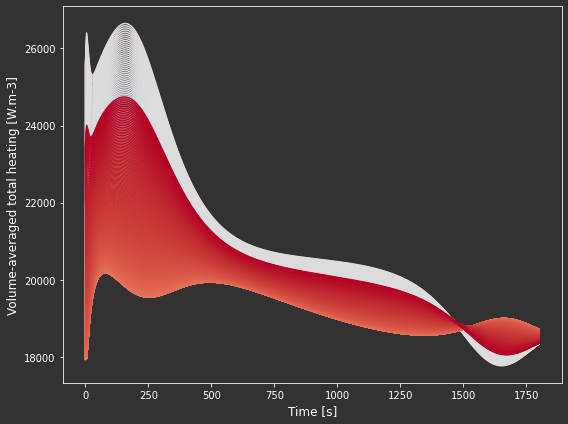

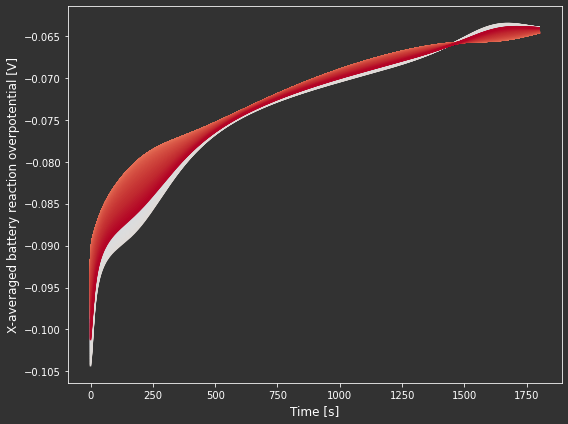

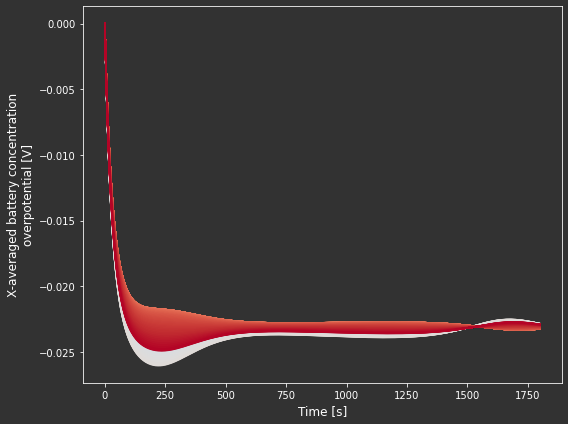

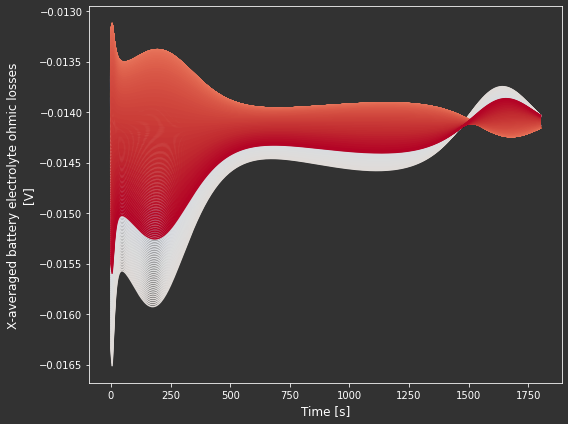

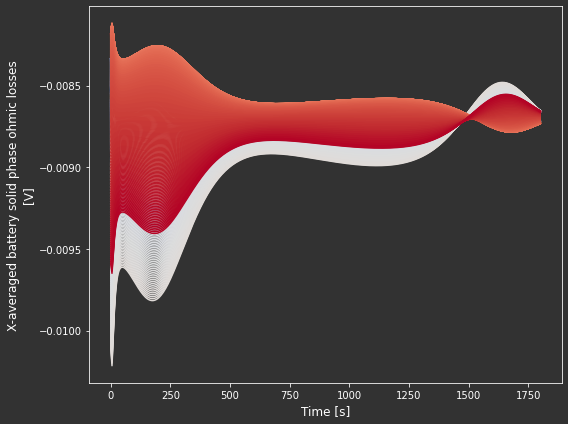

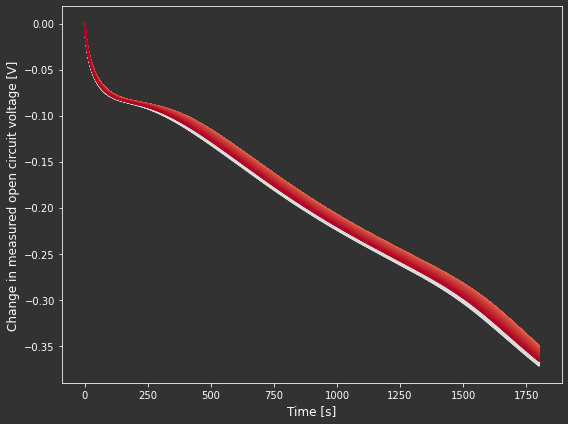

In [ ]:
lp.plot_output(output)

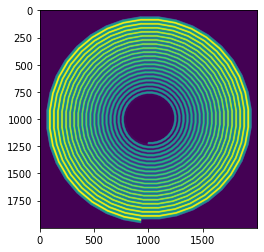

In [ ]:
im_spm_map = ecm.interpolate_spm_number(project).astype(int)

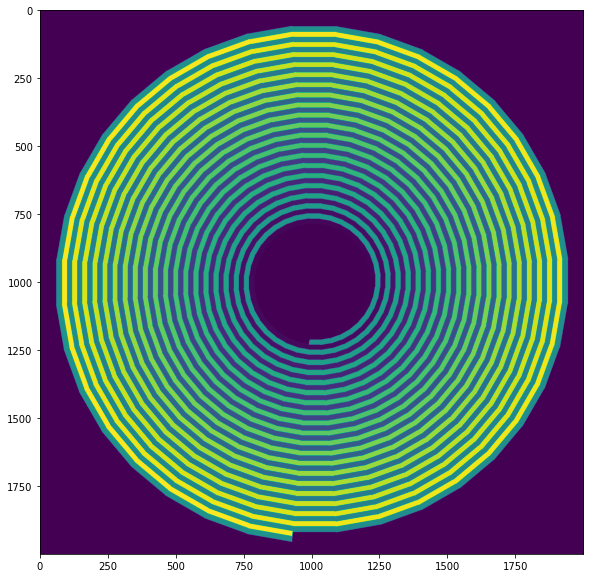

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [ ]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [ ]:
mask = im_spm_map == -1

In [ ]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Change in measured open circuit voltage [V]'])

In [ ]:
t_data = output['Volume-averaged cell temperature [K]'][-1, :]
i_data = output['Current collector current density [A.m-2]'][-1, :]

In [ ]:
arr = np.ones_like(im_spm_map).astype(float)

In [ ]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

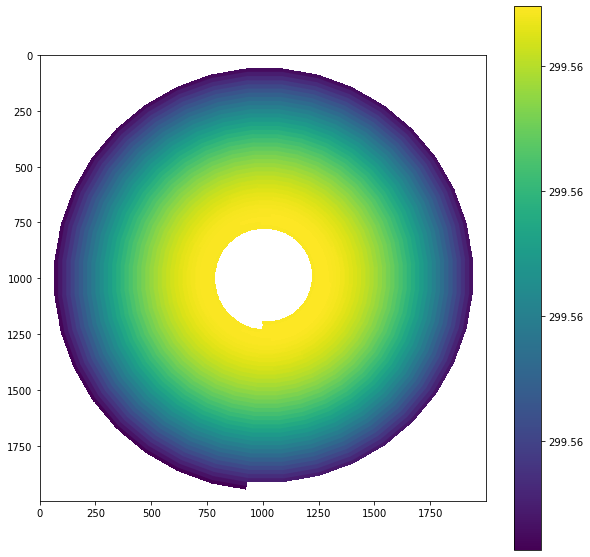

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [ ]:
t_data.max() - t_data.min()


2.1744710807070078e-05